In [38]:
import os
import ast
import sys
import cv2
import json
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
sys.path.append('./')
from utils import normalize_image, plot_image, plot_images

## Training set focal loss analysis

In [19]:
# data_root = '/data/jupiter/datasets'
data_root = '/data2/jupiter/datasets'

# dataset = 'Jupiter_train_v5_11'
# dataset = 'Jupiter_train_v6_1_v2'
dataset = 'Jupiter_train_v6_2'
csv = os.path.join(data_root, dataset, 'master_annotations.csv')

# dataset = 'Jupiter_halo_rgbnir_stereo_train_20230822_with_4_camera_implement_from_two_parts_subset_blur_dark_bright_label_proportion_planter_swapped_cams_reordered_cams_ocal_corrected_ocal_no_artifact_fix'
# dataset = '20230925_halo_rgb_stereo_train_v3'
# csv = os.path.join(data_root, dataset, 'master_annotations.csv')

data_df = pd.read_csv(csv, low_memory=False)
data_df.shape

(321638, 424)

(321638, 424)

In [13]:
data_df_v61 = data_df.copy()
data_df_v62 = data_df.copy()
print(data_df_v61.shape, data_df_v62.shape)
data_df_v62_delta = data_df_v62[~data_df_v62.id.isin(data_df_v61.id)]
data_df_v62_delta.to_csv('/data2/jupiter/datasets/Jupiter_train_v6_2/v62_delta_from_v61.csv', index=False)

((320715, 434), (321638, 424))

In [21]:
# remove large focal loss images
cur_df = data_df.copy()
csvs = [
        # '/data/jupiter/li.yu/exps/driveable_terrain_model/v510_8cls_0404/Jupiter_train_v5_11_epoch0/output.csv',
        # '/data/jupiter/li.yu/exps/driveable_terrain_model/v510_8cls_0404/Jupiter_train_v5_11_epoch5/output.csv',
        # '/data/jupiter/li.yu/exps/driveable_terrain_model/v510_8cls_0404/Jupiter_train_v5_11_epoch30/output.csv',
        # '/data/jupiter/li.yu/exps/driveable_terrain_model/v510_4cls_0404/Jupiter_train_v5_11_epoch0/output.csv',
        # '/data/jupiter/li.yu/exps/driveable_terrain_model/v510_4cls_0404/Jupiter_train_v5_11_epoch5/output.csv',
        # '/data/jupiter/li.yu/exps/driveable_terrain_model/v510_4cls_0404/Jupiter_train_v5_11_epoch30/output.csv',
        '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_7cls_0924/Jupiter_train_v6_1_v2_epoch0/output.csv',
        '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_7cls_0924/Jupiter_train_v6_1_v2_epoch5/output.csv',
        '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_7cls_0924/Jupiter_train_v6_1_v2_epoch30/output.csv',
        '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_7cls_0924/Jupiter_train_v6_2_epoch0/output.csv',
        '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_7cls_0924/Jupiter_train_v6_2_epoch5/output.csv',
        '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_7cls_0924/Jupiter_train_v6_2_epoch30/output.csv',
        # '/data/jupiter/li.yu/exps/driveable_terrain_model/rakhil_finetune_rgbd_0517_2/Jupiter_halo_labeled_data_20230517_train_stereo_640_768_single_ds_pmehta_oc_correctscale/output.csv0',
        # '/data/jupiter/li.yu/exps/driveable_terrain_model/rakhil_finetune_rgbd_0517_2/Jupiter_halo_labeled_data_20230517_train_stereo_640_768_single_ds_pmehta_oc_correctscale/output.csv1',
        # '/data/jupiter/li.yu/exps/driveable_terrain_model/halo0822_8cls_0902/Jupiter_halo_rgbnir_stereo_train_20230822_with_4_camera_implement_from_two_parts_subset_blur_dark_bright_label_proportion_planter_swapped_cams_reordered_cams_ocal_corrected_ocal_no_artifact_fix_epoch0/output.csv',
        # '/data/jupiter/li.yu/exps/driveable_terrain_model/halo0822_8cls_0902/Jupiter_halo_rgbnir_stereo_train_20230822_with_4_camera_implement_from_two_parts_subset_blur_dark_bright_label_proportion_planter_swapped_cams_reordered_cams_ocal_corrected_ocal_no_artifact_fix_epoch2/output.csv',
        # '/data/jupiter/li.yu/exps/driveable_terrain_model/halo0822_8cls_0902/Jupiter_halo_rgbnir_stereo_train_20230822_with_4_camera_implement_from_two_parts_subset_blur_dark_bright_label_proportion_planter_swapped_cams_reordered_cams_ocal_corrected_ocal_no_artifact_fix_epoch4/output.csv',
        # '/data/jupiter/li.yu/exps/driveable_terrain_model/halo0822_8cls_0902/Jupiter_halo_rgbnir_stereo_train_20230822_with_4_camera_implement_from_two_parts_subset_blur_dark_bright_label_proportion_planter_swapped_cams_reordered_cams_ocal_corrected_ocal_no_artifact_fix_epoch30/output.csv',
        # '/data/jupiter/li.yu/exps/driveable_terrain_model/rgb_baseline_sample_a_v3_2/20230925_halo_rgb_stereo_train_v3_epoch0/output.csv',
        ]
focal_loss_cutoff = 0.5
combined = False  # True when output.csv0, output.csv1, ...
if combined:
        focal_loss_df = pd.concat([pd.read_csv(focal_loss_csv) for focal_loss_csv in csvs], ignore_index=True)
        high_loss_df = focal_loss_df[focal_loss_df.focal_loss >= focal_loss_cutoff]
        cur_df = cur_df[~cur_df.unique_id.isin(high_loss_df.unique_id)]
        print(f'prune dataset by {csvs} under cutoff loss value {focal_loss_cutoff}')
        print(cur_df.shape)
else:
        for focal_loss_csv in csvs:
                focal_loss_df = pd.read_csv(focal_loss_csv)
                high_loss_df = focal_loss_df[focal_loss_df.focal_loss >= focal_loss_cutoff]
                cur_df = cur_df[~cur_df.id.isin(high_loss_df.id)]
                print(f'prune dataset by {focal_loss_csv} under cutoff loss value {focal_loss_cutoff}')
                print(cur_df.shape)
# cur_df.to_csv('/data/jupiter/li.yu/data/Jupiter_train_v6_1/epoch0_5_30_focal05_master_annotations.csv', index=False)
cur_df.to_csv(os.path.join(data_root, dataset, 'v61base_epoch0_5_30_focal05_master_annotations.csv'), index=False)

prune dataset by /data/jupiter/li.yu/exps/driveable_terrain_model/v61_7cls_0924/Jupiter_train_v6_1_v2_epoch0/output.csv under cutoff loss value 0.5
(319017, 424)
prune dataset by /data/jupiter/li.yu/exps/driveable_terrain_model/v61_7cls_0924/Jupiter_train_v6_1_v2_epoch5/output.csv under cutoff loss value 0.5
(318902, 424)
prune dataset by /data/jupiter/li.yu/exps/driveable_terrain_model/v61_7cls_0924/Jupiter_train_v6_1_v2_epoch30/output.csv under cutoff loss value 0.5
(318892, 424)
prune dataset by /data/jupiter/li.yu/exps/driveable_terrain_model/v61_7cls_0924/Jupiter_train_v6_2_epoch0/output.csv under cutoff loss value 0.5
(318875, 424)
prune dataset by /data/jupiter/li.yu/exps/driveable_terrain_model/v61_7cls_0924/Jupiter_train_v6_2_epoch5/output.csv under cutoff loss value 0.5
(318874, 424)
prune dataset by /data/jupiter/li.yu/exps/driveable_terrain_model/v61_7cls_0924/Jupiter_train_v6_2_epoch30/output.csv under cutoff loss value 0.5
(318874, 424)


In [25]:
# get pruned df by unique id
pruned_df = data_df[~data_df.id.isin(cur_df.id)]
print(pruned_df.shape)
ids = pruned_df.sample(5).id.to_list()
for id in ids:
    print(id)

(2764, 424)
63a29c1b0b504465f17b3ebf
63a2bba0baaeaf17ba704682
6360f3a9ece9514ba0b5e59c
64822d13d41683e437b12d85
651d69017a541635a344c28b


In [13]:
# check focal loss sum
focal_loss_df = pd.read_csv(csvs[0])
pruned_df = pruned_df.merge(focal_loss_df, on='unique_id')
cur_df = cur_df.merge(focal_loss_df, on='unique_id')
print(pruned_df.shape, cur_df.shape)
pruned_sum, cur_sum = pruned_df.focal_loss.sum(), cur_df.focal_loss.sum()
f'{pruned_sum:.2f}, {cur_sum:.2f}, pruned loss percentage: {pruned_sum / (pruned_sum + cur_sum) * 100:.1f}%'

(180, 283) (44928, 283)


'317.60, 1116.75, pruned loss percentage: 22.1%'

In [20]:
# load label pixel count data
label_csv = os.path.join('/data/jupiter/li.yu/data/Jupiter_train_v5_7/label_count.csv')
label_df = pd.read_csv(label_csv)
label_df = label_df.set_index('id')
label_df = label_df.reindex(index=data_df['id'])
label_df = label_df.reset_index()
label_df.shape

(307530, 8)

In [29]:
fronthv_df = data_df[(data_df.camera_location.str.startswith('front')) & ((label_df.Humans > 100) | (label_df.Vehicles > 100))]
rear_df = data_df[(~data_df.camera_location.str.startswith('front'))]
data_df2 = pd.concat([fronthv_df, rear_df], ignore_index=True)
print(data_df2.shape)

(188545, 276)


In [27]:
# sub_df = data_df[(data_df.hdr_mode != True) & ((label_df.Humans > 100) | (label_df.Vehicles > 100))]
sub_df = data_df[data_df.hdr_mode == True]
sub_df.shape

(164788, 276)

(1, 283)
64e565727f52e295073c3ac3 [ 0  7 14 19] ['Sky', 'implement', 'Ego Tractor'] 5.0657172203063965


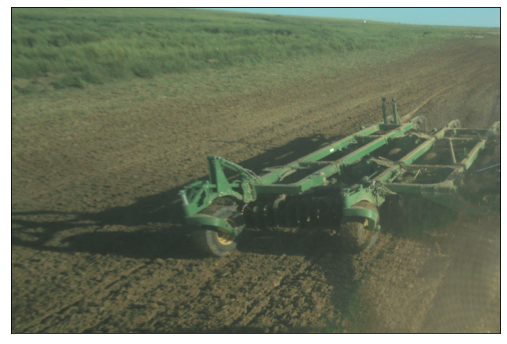

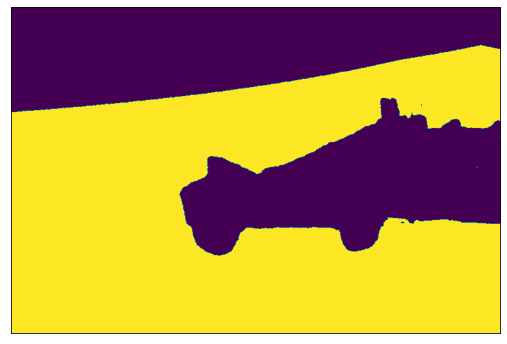

In [23]:
sub_df = pruned_df[pruned_df.id.isin(['64e565727f52e295073c3ac3'])]
# sub_df = pruned_df
print(sub_df.shape)
sub_df2 = sub_df.sample(min(5, len(sub_df)))

for i,row in sub_df2.iterrows():
    data_path = os.path.join(data_root, dataset, row.stereo_pipeline_npz_save_path)
    img = np.load(data_path)['left']
    img = normalize_image(img, row.hdr_mode)
    if isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(data_root, dataset, row.rectified_label_save_path)
        lbl = np.load(label_path)['left']
        labels = np.unique(lbl)
        label_map = json.loads(row.label_map)
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.image_id, labels, label_strs, row.focal_loss)
        # print(row.image_id, label_strs)
        plot_image(img)
        plot_image(lbl == 19)

## Check label pixel counts and prune training data

In [3]:
df1 = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v5_7/epoch0_5_30_focal05_master_annotations.csv')
df2 = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v5_7/label_count.csv')
df1.shape, df2.shape

/home/li.yu/anaconda3/envs/shank/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3134: DtypeWarning: Columns (6,7,12,39,109,110,112,130,186,212,241,271) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


((303974, 276), (307530, 8))

In [4]:
# tiny_df = df2[
#     ((df2['Driveable'] > 0) & (df2['Driveable'] < 30)) | 
#     ((df2['Non-driveable'] > 0) & (df2['Non-driveable'] < 30)) | 
#     ((df2['Sky'] > 0) & (df2['Sky'] < 30)) | 
#     ((df2['Trees_Weeds'] > 0) & (df2['Trees_Weeds'] < 30)) | 
#     ((df2['Implement'] > 0) & (df2['Implement'] < 30)) | 
#     ((df2['Humans'] > 0) & (df2['Humans'] < 30)) | 
#     ((df2['Vehicles'] > 0) & (df2['Vehicles'] < 30))
#     ]
tiny_df = df2[
    ((df2['Driveable'] > 0) & (df2['Driveable'] < 30)) |
    ((df2['Non-driveable'] > 0) & (df2['Non-driveable'] < 20) & 
        ((df2['Humans'] == 0) | (df2['Humans'] <= 30)) & 
        ((df2['Vehicles'] == 0) | (df2['Vehicles'] <= 30))) |
    ((df2['Sky'] > 0) & (df2['Sky'] < 30)) | 
    ((df2['Trees_Weeds'] > 0) & (df2['Trees_Weeds'] < 30)) | 
    ((df2['Implement'] > 0) & (df2['Implement'] < 30)) | 
    ((df2['Humans'] > 0) & (df2['Humans'] < 30)) | 
    ((df2['Vehicles'] > 0) & (df2['Vehicles'] < 30))
    ]
tiny_df.shape

(5766, 8)

In [24]:
left_df = pd.read_csv('/data/jupiter/datasets/Jupiter_train_v5_7/master_annotations_left.csv')
print(left_df.shape)
df1_notiny = df1[~df1.id.isin(tiny_df.id)]
print(df1_notiny.shape)
df1_notiny_onlyleft = df1_notiny[df1_notiny.id.isin(left_df.id)]
print(df1_notiny_onlyleft.shape)
df1_notiny_onlyleft.to_csv('/data/jupiter/li.yu/data/Jupiter_train_v5_7/epoch0_5_30_focal05_notiny_onlyleft_master_annotations.csv', index=False)

/home/li.yu/anaconda3/envs/shank/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3134: DtypeWarning: Columns (6,7,12,39,109,110,112,130,136,186,212,241,271) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(299655, 276)
(298250, 276)
(290679, 276)


In [5]:
df3 = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v5_7/trainrd05_humanaug_dp.csv')
print(df3.shape)
print(df3[(df3.pixel_count > 0)].shape)
print(df3[((df3.pixel_count > 0)) & (df3.pixel_count < 30)].shape)

/home/li.yu/anaconda3/envs/shank/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3134: DtypeWarning: Columns (6,7,12,39,109,110,112,130,141,143,186,212,241,271) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(288919, 295)
(51235, 295)
(196, 295)


In [6]:
subdf1 = df3[df3.id.isin(tiny_df.id)]
subdf2 = df3[df3.id.isin(tiny_df.id) & (df3.pixel_count > 0)]
subdf1.shape, subdf2.shape

((5465, 295), (420, 295))

In [7]:
subdf2[['id', 'operation_time']].groupby(['operation_time']).count()

,id
operation_time,
dawn_dusk,19
daytime,132
nightime,147
unknown,1


In [11]:
subdf2[subdf2.id == '604933cc475fbf32f72550b7'].pixel_count
tiny_df[tiny_df.id == '604933cc475fbf32f72550b7']

,id,Driveable,Non-driveable,Sky,Trees_Weeds,Implement,Humans,Vehicles
282061,604933cc475fbf32f72550b7,499694,1965,0,23,19109,3497,0


In [9]:
d = subdf2[['id', 'pixel_count']].sample(5)
l = d.id.to_list()
for i in l:
    print(i)

636096ebd364d5c4db997bf7
61a6ab3140e899632d2cf99e
5f1b789307f97ba0ba105fbd
62fe130539f8399f18d22334
61280eb4f04a1ace266697d2


## Facets visualization

In [3]:
# seg prediction
cls3_pred = '/data/jupiter/li.yu/exps/driveable_terrain_model/v51_3cls_tversky001_imgaug_100p_0109_dustv51_0126'
# cls4_pred = '/data/jupiter/li.yu/exps/driveable_terrain_model/v51_4cls_tversky001_imgaug_100p_0109'
cls4_pred = '/data/jupiter/li.yu/exps/driveable_terrain_model/v53_4cls_tversky001_imgaug_60p_0209'
# cls4_pred = '/data/jupiter/li.yu/exps/driveable_terrain_model/v57rd_4cls_tiny0occluded5reverse5triangle5_msml_0305'
# cls4_pred = '/data/jupiter/li.yu/exps/driveable_terrain_model/v58rd_4cls_0314'
models = [
    'v51_3cls_tversky001_imgaug_100p_0109_dustv51_0126',
    'v53_4cls_tversky001_imgaug_60p_0209',
    'v57rd_4cls_tiny0occluded5reverse5triangle5_msml_0305',
    'v58rd_4cls_0314']
datasets = [
#     'Jupiter_vt_dust_8_10mph_Jan2023_2',
    'Jupiter_2023_03_28_Loamy_619_stops_stereo_2',
    'Jupiter_2023_03_28_Loamy_812_stops_stereo',
    'Jupiter_2023_03_29_Loamy_812_stops_after_2pm_left_images_rear_pod_stereo',
    'Jupiter_2023_03_29_10pm_30_3pm_Loamy_812_stops_stereo_2'
]
cls3_dfs_, cls4_dfs_ = [], []

for dataset in datasets:
    cls3_df_ = pd.read_csv(os.path.join(cls3_pred, dataset, 'output.csv'))
    cls4_df_ = pd.read_csv(os.path.join(cls4_pred, dataset+'_oldmask', 'output.csv'))
    print(cls3_df_.shape, cls4_df_.shape)

    # dust detection
    cls3_dust_df_ = pd.read_csv(os.path.join(cls3_pred, dataset+'_dust', 'output.csv'))
    cls3_dust_df_['pred_dust_ratio'] = cls3_dust_df_['pred_dust_ratio'] / 100
    cls4_dust_df_ = pd.read_csv(os.path.join(cls4_pred, dataset+'_oldmask', 'dust_ratio.csv'))
    if not 'id' in cls4_dust_df_:
        cls4_dust_df_['id'] = cls4_dust_df_['image_id']
    print(cls3_dust_df_.shape, cls4_dust_df_.shape)

    # merge seg df and dust df
    cls3_dft_ = cls3_df_.merge(cls3_dust_df_[['id', 'gt_dust_label', 'pred_dust_ratio']], on='id')
    cls4_dft_ = cls4_df_.merge(cls4_dust_df_, on='id')
    print(cls3_dft_.shape, cls4_dft_.shape)
    
    cls3_dfs_.append(cls3_dft_)
    cls4_dfs_.append(cls4_dft_)
cls3_df = pd.concat(cls3_dfs_, ignore_index=True)
cls4_df = pd.concat(cls4_dfs_, ignore_index=True)
print('total', cls3_df.shape, cls4_df.shape)
# cls3_df = cls3_df[cls3_df.camera_location == 'rear-left']
# cls4_df = cls4_df[cls4_df.camera_location == 'rear-left']
cls3_df = cls3_df[cls3_df.camera_location.str.startswith('side')]
cls4_df = cls4_df[cls4_df.camera_location.str.startswith('side')]
print('total', cls3_df.shape, cls4_df.shape)

(6935, 7) (6935, 9)
(6935, 11) (6935, 5)
(6935, 9) (6935, 13)
(160, 7) (160, 9)
(160, 11) (160, 5)
(160, 9) (160, 13)
(8906, 7) (8906, 9)
(8906, 11) (8906, 5)
(8906, 9) (8906, 13)
(36206, 7) (36206, 9)
(36206, 11) (36206, 5)
(36206, 9) (36206, 13)
total (52207, 9) (52207, 13)
total (20599, 9) (20599, 13)


In [4]:
# create a csv for facets visualization
data_root = '/data/jupiter/li.yu/data'
master_dfs = []
for dataset in datasets:
    master_dfs.append(pd.read_csv(os.path.join(data_root, dataset, 'master_annotations.csv')))
master_df = pd.concat(master_dfs, ignore_index=True)
# master_df = master_df[master_df.camera_location == 'rear-left']
# master_df = master_df[master_df.camera_location.str.startswith('side')]
print(master_df.shape)

# prepare 3-class columns
cls3_df_toadd = cls3_df[['id', 'state', 'pred_dust_ratio']].rename(columns={'state':'3-class state', 'pred_dust_ratio': '3-class pred dust ratio'})
# cls3_df_toadd['3-class pred dust ratio'] = cls3_df_toadd['3-class pred dust ratio'] / 100
print(cls3_df_toadd.shape)
# cls3_df_toadd.head()

/home/li.yu/anaconda3/envs/shank/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3134: DtypeWarning: Columns (117) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/li.yu/anaconda3/envs/shank/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3134: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(52207, 127)
(20599, 3)


In [5]:
master_df.to_csv('/data/jupiter/li.yu/exps/driveable_terrain_model/v53_4cls_tversky001_imgaug_60p_0209/master_annotations.csv', index=False)

In [10]:
# prepare 4-class columns
cls4_df_toadd = cls4_df[['id', 'state', 'total_averaged_dust_ratio', 'triangle_averaged_dust_ratio']]
cls4_df_toadd = cls4_df_toadd.rename(columns={'state':'4-class state', 
                                              'total_averaged_dust_ratio': '4-class pred dust ratio in entire image',
                                              'triangle_averaged_dust_ratio': '4-class pred dust ratio in new mask'})
print(cls4_df_toadd.shape)
# cls4_df_toadd.head()

(4238, 4)


In [30]:
# prepare 4-class columns
cls4_df_toadd2 = cls4_df[['id', 'state', 'total_averaged_dust_ratio']]
cls4_df_toadd2 = cls4_df_toadd2.rename(columns={'state':'4-class state', 'total_averaged_dust_ratio': '4-class pred dust ratio in entire image'})
# cls4_df_toadd2 = cls4_df[['id', 'triangle_averaged_dust_ratio']]
# cls4_df_toadd2 = cls4_df_toadd2.rename(columns={'triangle_averaged_dust_ratio': '4-class pred dust ratio in old mask'})
print(cls4_df_toadd2.shape)
# cls4_df_toadd2.head()

(8456, 3)


In [31]:
# merge with annotations.csv
master_df = master_df.merge(cls3_df_toadd, on='id')
# master_df = master_df.merge(cls4_df_toadd, on='id')
master_df = master_df.merge(cls4_df_toadd2, on='id')
print(master_df.shape)

(8456, 129)


In [33]:
# # select only human images within depth threshold
# human_df = cls3_df[(cls3_df.state == 'true_positive') | (cls3_df.state == 'false_negative')]
# master_df = master_df[master_df.id.isin(human_df.id)]

# piece together 3-class and 4-class predictions
master_df['facets_img_name'] = ''
facets_path = os.path.join(cls4_pred, 'forfacets')
os.makedirs(facets_path, exist_ok=True)
for i,row in master_df.iterrows():
    for dataset in datasets:
        data_path = os.path.join(data_root, dataset, 'processed/images', row.image_id, 'stereo_output.npz')
        if os.path.isfile(data_path):
            img = np.load(data_path)['left']
            img = normalize_image(img, row.hdr_mode)
            img = (img * 255).astype(np.uint8)

    # load 3-class pred
    dust_ratio = row['3-class pred dust ratio']
    img = cv2.putText(img, f'3-class dust ratio in entire image: {dust_ratio*100:.2f}%', 
                        (40,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    # load 4-class pred
    dust_ratio = row['4-class pred dust ratio in entire image']
    img = cv2.putText(img, f'4-class dust ratio in entire image: {dust_ratio*100:.2f}%', 
                        (40,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    # dust_ratio = row['4-class pred dust ratio in new mask']
    # img = cv2.putText(img, f'4-class dust ratio in new mask: {dust_ratio*100:.2f}%', 
    #                     (40,110), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    # dust_ratio = row['4-class pred dust ratio in old mask']
    # img = cv2.putText(img, f'4-class dust ratio in old mask: {dust_ratio*100:.2f}%', 
    #                     (40,140), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)

    # save image and update column
    facets_img_name = f'{row.id}.png'
    cv2.imwrite(os.path.join(facets_path, facets_img_name), img)
    master_df.at[i,'facets_img_name'] = facets_img_name

save_path = os.path.join(cls4_pred, 'forfacets_4cls_side.csv')
master_df.to_csv(save_path, index=False)
print(f'write new csv to {save_path}')

write new csv to /data/jupiter/li.yu/exps/driveable_terrain_model/v53_4cls_tversky001_imgaug_60p_0209/forfacets_4cls_side.csv


In [36]:
master_df['datehour'] = master_df.collected_on.apply(lambda x: str(x)[:16])
fp_4cls = master_df[master_df['4-class state'] == 'false_positive']
fp_4cls.groupby(['datehour']).count()

,artifact_debayeredrgb_0__id,artifact_debayeredrgb_0_content_hash,artifact_debayeredrgb_0_created_at,artifact_debayeredrgb_0_id,artifact_debayeredrgb_0_image,artifact_debayeredrgb_0_kind,artifact_debayeredrgb_0_project_name,artifact_debayeredrgb_0_s3_bucket,artifact_debayeredrgb_0_s3_key,artifact_debayeredrgb_0_save_path,...,stereo_right_image,terrain_type,autonomy_state,teleop_request,teleop_response,3-class state,3-class pred dust ratio,4-class state,4-class pred dust ratio in entire image,facets_img_name
datehour,,,,,,,,,,,,,,,,,,,,,
2023-03-29T18:41,10,10,10,10,10,10,10,10,10,10,...,10,0,0,0,0,10,10,10,10,10
2023-03-29T19:01,7,7,7,7,7,7,7,7,7,7,...,7,0,0,0,0,7,7,7,7,7
2023-03-29T21:04,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,1,1,1,1,1
2023-03-29T21:11,2,2,2,2,2,2,2,2,2,2,...,2,0,0,0,0,2,2,2,2,2
2023-03-29T21:12,8,8,8,8,8,8,8,8,8,8,...,8,0,0,0,0,8,8,8,8,8
2023-03-29T21:24,4,4,4,4,4,4,4,4,4,4,...,4,0,0,0,0,4,4,4,4,4
2023-03-29T22:15,32,32,32,32,32,32,32,32,32,32,...,32,0,0,1,1,32,32,32,32,32
2023-03-29T22:16,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,1,1,1,1,1
2023-03-29T22:17,10,10,10,10,10,10,10,10,10,10,...,10,0,0,0,0,10,10,10,10,10


In [2]:
ms_df = pd.read_csv('/data/jupiter/datasets/humans_on_path_test_set_2023_v6_anno/master_annotations.csv')
print(ms_df.shape)
sub_df = ms_df[(ms_df.id == '63a25b4b61627e618ba0acd9') | (ms_df.id == '619787aa2bd5a9c3dede616f')]
sub_df.to_csv('/home/li.yu/code/scripts/master_annotations.csv', index=False)

(19883, 195)


/home/li.yu/anaconda3/envs/shank/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3134: DtypeWarning: Columns (20,83,84,139,140) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Check dedust results

In [8]:
data_dir = '/data/jupiter/li.yu/data/Jupiter_2023_03_02_and_2930_human_vehicle_in_dust_labeled'
original_dir = os.path.join(data_dir, 'original')
dedust_dir = os.path.join(data_dir, 'dedusted')
pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/v57rd_4cls_tiny0occluded5reverse5triangle5_msml_0305'
original = 'Jupiter_2023_03_02_and_2930_human_vehicle_in_dust_labeled_epoch43_original'
dedust = 'Jupiter_2023_03_02_and_2930_human_vehicle_in_dust_labeled_epoch43_dedust'
original_df = pd.read_csv(os.path.join(pred_dir, original, 'output.csv'))
dedust_df = pd.read_csv(os.path.join(pred_dir, dedust, 'output.csv'))
original_df.shape, dedust_df.shape

((7569, 10), (7569, 10))

In [7]:
sub_df = original_df[(original_df.state == 'true_positive') & (dedust_df.state != 'true_positive')]
print(sub_df.shape)

(46, 10)


(512, 1024, 3) (512, 1024, 3)


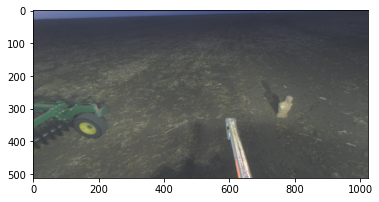

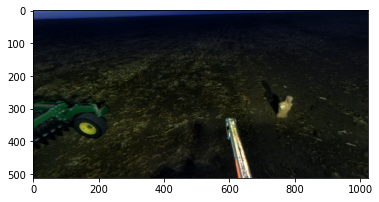

(512, 1024, 3) (512, 1024, 3)


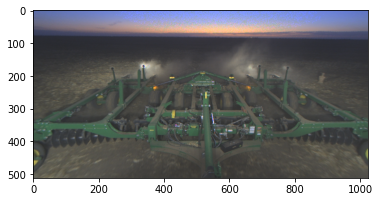

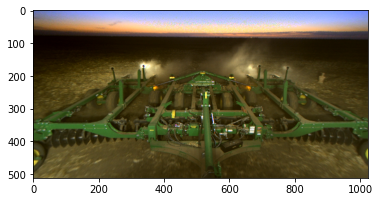

In [16]:
for i,row in sub_df.sample(2).iterrows():
    original_img = cv2.cvtColor(cv2.imread(os.path.join(original_dir, row.id+'.png')), cv2.COLOR_BGR2RGB)
    dedust_img = cv2.cvtColor(cv2.imread(os.path.join(dedust_dir, row.id+'.png')), cv2.COLOR_BGR2RGB)
    print(original_img.shape, dedust_img.shape)
    plt.imshow(original_img)
    plt.show()
    plt.imshow(dedust_img)
    plt.show()

In [3]:
df = pd.read_csv('/data/jupiter/li.yu/exps/driveable_terrain_model/v188_58d_rak_local_fine_tversky11_sum_image_normT_prod5_airdyn_r3a8_s30/mannequin_in_dust_v1/summary.csv')
df.shape

(2261, 31)

In [7]:
df.columns

Index(['Unnamed: 0', 'id', 'camera_location', 'operation_time', 'collected_on',
       'error', 'num_classes', 'iq_status', 'dust_percent', 'predicted_stop',
       'label_stop', 'predicted_human', 'label_human', 'predicted_vehicle',
       'label_vehicle', 'stop_nostop_metrics', 'are_stop_objects_filtered',
       'stricter_stop_nostop_metrics', 'product_metrics_safety',
       'product_metrics_nodamage', 'product_metrics_productivity',
       'pixseg_metrics_precision', 'pixseg_metrics_recall',
       'pixseg_metrics_f_score', 'predicted_grid_details',
       'label_grid_details', 'stop_in_object_locator', 'iq_stop',
       'filter_intermediate_output', 'predicted_stop_class',
       'label_stop_class'],
      dtype='object')

In [6]:
df.groupby(['label_stop', 'predicted_stop']).count()

Unnamed: 0    id  camera_location  operation_time  \
label_stop predicted_stop                                                      
False      False                  480   480              480             480   
           True                    49    49               49              49   
True       False                  130   130              130             130   
           True                  1602  1602             1602            1602   

                           collected_on  error  num_classes  iq_status  \
label_stop predicted_stop                                                
False      False                    480      0          480        480   
           True                      49      0           49         49   
True       False                    130      0          130        130   
           True                    1602      0         1602       1602   

                           dust_percent  predicted_human  ...  \
label_stop predicted_stop                                 ...   
False      False                    480              480  ...   
           True                      49               49  ...   
True       False                    130              130  ...   
           True                    1602             1602  ...   

                           pixseg_metrics_precision  pixseg_metrics_recall  \
label_stop predicted_stop                                                    
False      False                                480                    480   
           True                                  49                     49   
True       False                                130                    130   
           True                                1602                   1602   

                           pixseg_metrics_f_score  predicted_grid_details  \
label_stop predicted_stop                                                   
False      False                              480                     480   
           True                                49                      49   
True       False                              130                     130   
           True                              1602                    1602   

                           label_grid_details  stop_in_object_locator  \
label_stop predicted_stop                                               
False      False                          480                     480   
           True                            49                      49   
True       False                          130                     130   
           True                          1602                    1602   

                           iq_stop  filter_intermediate_output  \
label_stop predicted_stop                                        
False      False               480                         480   
           True                 49                          49   
True       False               130                         130   
           True               1602                        1602   

                           predicted_stop_class  label_stop_class  
label_stop predicted_stop                                          
False      False                            480               480  
           True                              49                49  
True       False                            130               130  
           True                            1602              1602  

[4 rows x 29 columns]

## Compare RGB and debayeredRGB inputs

In [8]:
pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model'
# run_id = 'v62_50k_lite12_debayer_512x832_0223'
# run_id = 'v62_50k_lite12_debayer_768x1248_0223'
run_id = 'v62_50k_nextvitsmall_debayer_512x832_0223'
# run_id = 'v62_50k_nextvitsmall_debayer_768x1248_0223'

dataset = 'halo_humans_on_path_test_v6_2_2_test_dataset'
# dataset = 'halo_rgb_stereo_test_v6_2'

if '512' in run_id:
    rgb_input_suffix = '_RGBD_0,0'
    debayeredrgb_input_suffix = '_debayeredRGB_512,832'
    debayered2rectifiedrgb_input_suffix = '_debayered2rectifiedRGBD_512,832'
else:
    rgb_input_suffix = '_768_RGBD_0,0'
    debayeredrgb_input_suffix = '_debayeredRGB_768,1248'
    debayered2rectifiedrgb_input_suffix = '_debayered2rectifiedRGBD_768,1248'
pred_data_dir = os.path.join(pred_dir, run_id, dataset)
print(pred_data_dir)

/data/jupiter/li.yu/exps/driveable_terrain_model/v62_50k_nextvitsmall_debayer_512x832_0223/halo_humans_on_path_test_v6_2_2_test_dataset


In [9]:
data_dir = '/data2/jupiter/datasets'
csv = 'master_annotations.csv'
df = pd.read_csv(os.path.join(data_dir, dataset, csv))
print(df.shape)

(16780, 326)


/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (23,80,91,92,93,94,95,97,98,100,101,102,103,104,105,106,107,108,118,178,179,185,187,197,198,202,203,204,205,225,230,231,232,235,237,241,252,253,286,287) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
# RGB input humans
out_df1 = pd.read_csv(os.path.join(pred_data_dir+rgb_input_suffix, 'output.csv'))
human_df1 = out_df1[(out_df1.state == 'true_positive') | (out_df1.state == 'false_negative')]
print(out_df1.shape, human_df1.shape, f"human recall: {len(human_df1[human_df1.state == 'true_positive'])/len(human_df1):.6f}")
print(human_df1[['unique_id', 'state']].groupby('state').count())
print()

# debayered RGB input
out_df2 = pd.read_csv(os.path.join(pred_data_dir+debayeredrgb_input_suffix, 'output.csv'))
print(out_df2.shape, f"human recall: {len(out_df2[out_df2.state == 'true_positive'])/len(out_df2[(out_df2.state == 'true_positive') | (out_df2.state == 'false_negative')]):.6f}")
human_df2 = out_df2[out_df2.unique_id.isin(human_df1.unique_id)]
print(out_df2.shape, human_df2.shape, f"human recall: {len(human_df2[human_df2.state == 'true_positive'])/len(human_df2[(human_df2.state == 'true_positive') | (human_df2.state == 'false_negative')]):.6f}")
print(human_df2[['unique_id', 'state']].groupby('state').count())
print()

# debayered2rectified RGB input
out_df31 = pd.read_csv(os.path.join(pred_data_dir+debayered2rectifiedrgb_input_suffix+'_640', 'output.csv'))
out_df32 = pd.read_csv(os.path.join(pred_data_dir+debayered2rectifiedrgb_input_suffix+'_768', 'output.csv'))
out_df3 = pd.concat([out_df31, out_df32], ignore_index=True)
print(out_df3.shape, f"human recall: {len(out_df3[out_df3.state == 'true_positive'])/len(out_df3[(out_df3.state == 'true_positive') | (out_df3.state == 'false_negative')]):.6f}")
human_df3 = out_df3[(out_df3.state == 'true_positive') | (out_df3.state == 'false_negative')]
print(out_df3.shape, human_df3.shape, f"human recall: {len(human_df3[human_df3.state == 'true_positive'])/len(human_df3[(human_df3.state == 'true_positive') | (human_df3.state == 'false_negative')]):.6f}")
print(human_df3[['unique_id', 'state']].groupby('state').count())

(15948, 11) (5555, 11) human recall: 0.994599
                unique_id
state                    
false_negative         30
true_positive        5525

(15948, 11) human recall: 0.988291
(15948, 11) (5555, 11) human recall: 0.996544
                unique_id
state                    
false_negative         19
false_positive         52
true_negative           6
true_positive        5478

(15948, 11) human recall: 0.996040
(15948, 11) (5555, 11) human recall: 0.996040
                unique_id
state                    
false_negative         22
true_positive        5533


In [21]:
human_df1v3 = human_df1[['unique_id', 'state']].merge(human_df3[['unique_id', 'state']], on='unique_id')
print(human_df1v3.shape)
# human_df1v3.head(2)

human_df1v3_diff = human_df1v3[human_df1v3.state_x != human_df1v3.state_y]
human_df1v3_diff.groupby(['state_x', 'state_y']).count()

(5555, 3)


,,unique_id
state_x,state_y,
false_negative,true_positive,22
true_positive,false_negative,14


In [32]:
# human_df_oi = human_df1[['unique_id', 'state']].merge(human_df2[['unique_id', 'state']], on='unique_id')
# print(human_df_oi.shape)
# human_df_diff = human_df_oi[human_df_oi.state_x != human_df_oi.state_y]
# human_df_fn = human_df_oi[(human_df_oi.state_x == 'false_negative') & (human_df_oi.state_y == 'false_negative')]
# human_df_2tn = human_df_oi[(human_df_oi.state_y == 'true_negative')]
# human_df_tp = human_df_oi[(human_df_oi.state_x == 'true_positive') & (human_df_oi.state_y == 'true_positive')]
# print(human_df_diff.shape, human_df_fn.shape, human_df_2tn.shape, human_df_tp.shape)
# human_df_2save = pd.concat([human_df_diff, human_df_fn, human_df_2tn, human_df_tp.sample(50)], ignore_index=True)
# print(human_df_2save.shape)
# human_df_2save_full = df[df.unique_id.isin(human_df_2save.unique_id)]
# print(human_df_2save_full.shape)
# human_df_2save_full.to_csv(os.path.join(pred_dir, run_id, dataset+'_pred_diff.csv'), index=False)

(5555, 3)
(89, 3) (8, 3) (6, 3) (5458, 3)
(153, 3)
(153, 326)


In [53]:
# RGB input negative images
out_df1 = pd.read_csv(os.path.join(pred_data_dir+rgb_input_suffix, 'output.csv'))
human_df1 = out_df1[(out_df1.state == 'true_negative') | (out_df1.state == 'false_positive')]
print(out_df1.shape, human_df1.shape, f"productivity: {len(human_df1[human_df1.state == 'true_negative'])/len(human_df1):.6f}")
print(out_df1[['unique_id', 'state']].groupby('state').count())
print()

# debayered RGB input
out_df2 = pd.read_csv(os.path.join(pred_data_dir+debayeredrgb_input_suffix, 'output.csv'))
human_df2 = out_df2[(out_df2.state == 'true_negative') | (out_df2.state == 'false_positive')]
print(out_df2.shape, human_df2.shape, f"productivity: {len(human_df2[human_df2.state == 'true_negative'])/len(human_df2):.6f}")
print(out_df2[['unique_id', 'state']].groupby('state').count())
# human_df2 = out_df2[out_df2.unique_id.isin(human_df1.unique_id)]
# print(out_df2.shape, human_df2.shape, f"productivity: {len(human_df2[human_df2.state == 'true_negative'])/len(human_df2[(human_df2.state == 'true_negative') | (human_df2.state == 'false_positive')]):.6f}")
# print(human_df2[['unique_id', 'state']].groupby('state').count())

(65052, 11) (48237, 11) productivity: 0.992205
                unique_id
state                    
false_negative       1896
false_positive        376
true_negative       47861
true_positive       14919

(65052, 11) (5681, 11) productivity: 0.875550
                unique_id
state                    
false_negative       4014
false_positive        707
true_negative        4974
true_positive       55357


(2, 326)
652dba5994e3afd8a4b59c5b T13


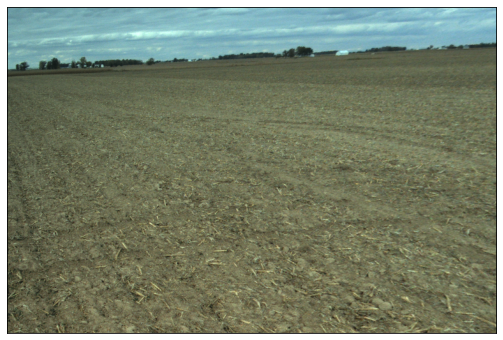

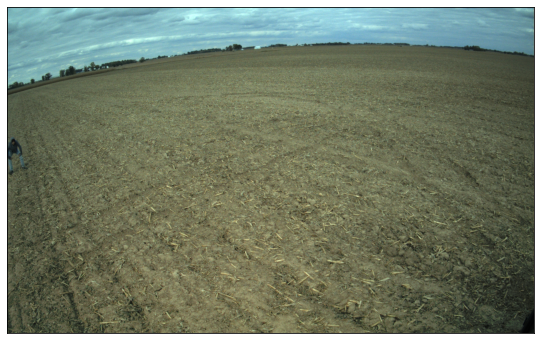

652da817568479cbd4884cf1 T10


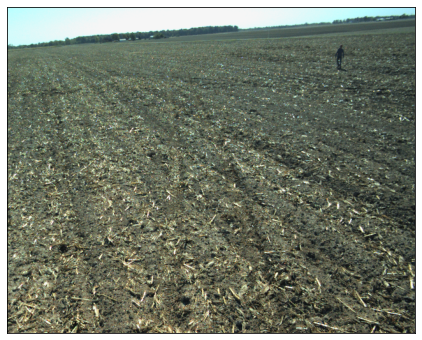

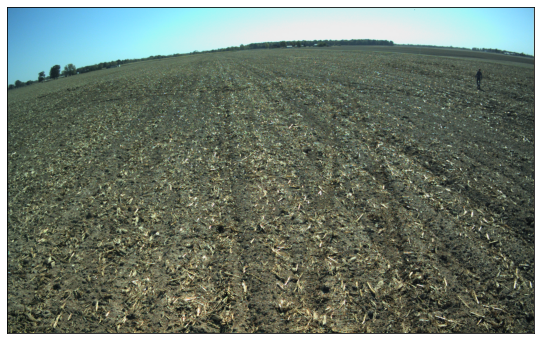

In [12]:
# sub_df = df[(df.unique_id.isin(human_df1[human_df1.state == 'false_negative'].unique_id))]
# sub_df = df[(df.unique_id.isin(human_df2[human_df2.state == 'false_negative'].unique_id))]
# sub_df = df[(df.unique_id.isin(out_df1[out_df1.state == 'true_negative'].unique_id))]
# sub_df = df[(df.unique_id.isin(out_df1[out_df1.state == 'true_negative'].unique_id))]
sub_df = df.sample(2)
print(sub_df.shape)
sub_df = sub_df.sample(n=min(2, len(sub_df)))
show_image, show_label = True, False
show_debayered_rgb, show_raw_label = True, False
show_pred_result = False

for i, row in sub_df.iterrows():
    # print(row.unique_id, row.gt_dust_ratio, row.total_averaged_dust_conf, row.total_thresholded_dust_ratio)
    print(row.id, row.camera_location)
    # print('rectified', out_df1[out_df1.unique_id == row.unique_id].iloc[0].state)
    # print('debayered', out_df2[out_df2.unique_id == row.unique_id].iloc[0].state)

    if show_image:
        data_path = os.path.join(data_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, True)
        plot_image(img_norm)

    if show_debayered_rgb:
        image = imageio.imread(os.path.join(data_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(data_dir, dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label == 25)

    if show_raw_label:
        label = imageio.imread(os.path.join(data_dir, dataset, row.annotation_pixelwise_0_save_path))
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        plot_image(label == 25)

    if show_pred_result:
        result_path = os.path.join(pred_data_dir+rgb_input_suffix, 'output_visualization', row.unique_id+'.png')
        if os.path.isfile(result_path):
            res_img = cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB)
            plot_image(res_img, figsize=(20, 6))
        result_path = os.path.join(pred_data_dir+debayeredrgb_input_suffix, 'output_visualization', row.unique_id+'.png')
        if os.path.isfile(result_path):
            res_img = cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB)
            plot_image(res_img, figsize=(20, 6))

## Safety dataset triaging

In [2]:
pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model'
models = [
    # 'v80_lite12_ptb_cnp_0326',
    # 'v81_lite12_dust_only_kore_v62seg_0406',
    # 'v81_nextvitsmall_dust_only_kore_dean_0406',
    # 'v81_nextvitsmall_dust_only_kore_ben_0406',
    # 'v62_50k_nextvitsmall_kore_0329',
    # 'ds_v8_1_nextvit_small_openimages_with_rev1_train_human_test_using_random_val_mhc_20_epochs_finetune_rev1_lr',
    # 'ds_v8_1_nextvit_small_openimages_using_random_val_50k_rev1_rev2_lying_down_sitting_2x_lower_airborne_birds_lower_msl_d',
    'v62_50k_nextvitsmall_kore_0323',
    'v81_80k_nextvitsmall_kore_0404',
    'v81_80k_nextvitsmall_nightsmallhuman2daysmall12_kore_0418',
    'v81_80k_maxfov_iwtv_nightsmallhuman2_ft_kore_0427',
]
datasets = [
    # "humans/on_path_forward/on_path_forward_humans_day_2024_rev2_v13", 
    # "humans/on_path_forward/on_path_forward_humans_night_2024_rev2_v19", 
    # "humans/on_path_aft/on_path_aft_humans_day_2024_rev2_v15", 
    # "humans/on_path_aft/on_path_aft_humans_night_2024_rev2_v14",
    "vehicles/on_path_forward/on_path_forward_vehicles_day_2024_rev2_v18", 
    # "vehicles/on_path_forward/on_path_forward_vehicles_night_2024_rev2_v14", 
    # "vehicles/on_path_aft/on_path_aft_vehicles_day_2024_rev2_v8_maxfov_alleysson_depth0423",
    # "vehicles/on_path_aft/on_path_aft_vehicle_night_2024_rev2_v10_maxfov_alleysson_depth0423",
    # "vehicles/off_path/off_path_vehicle_day_2024_rev2_v5_maxfov_alleysson_depth0423",
    # "vehicles/off_path/off_path_vehicles_night_2024_rev2_v6",
    "hazards/on_path_forward/on_path_forward_hazards_day_2024_rev2_v11",
    "hazards/on_path_aft/on_path_aft_hazards_night_2024_rev2_v12",
]

In [3]:
save_mi = 0
states = ['false_negative', 'true_negative', 'false_positive']
for state in states:
    print(f'\ncollect results for {state}')
    for di in range(len(datasets)):
        print(f'process {datasets[di]}')
        save_pred_dir = os.path.join(pred_dir, models[save_mi], datasets[di], f'{state}_sum5')
        os.makedirs(save_pred_dir, exist_ok=True)
        for model in models:
            fn_pred_dir = os.path.join(pred_dir, model, datasets[di], state)
            if not os.path.isdir(fn_pred_dir):
                print(f'     no inference result from {model}')
                continue
            fn_imgs = os.listdir(fn_pred_dir)
            print('    ', len(fn_imgs), model)
            for fn_img in fn_imgs:
                shutil.copy2(os.path.join(fn_pred_dir, fn_img), save_pred_dir)


collect results for false_negative
process vehicles/on_path_forward/on_path_forward_vehicles_day_2024_rev2_v18
     2 v62_50k_nextvitsmall_kore_0323
     1 v81_80k_nextvitsmall_kore_0404
     1 v81_80k_nextvitsmall_nightsmallhuman2daysmall12_kore_0418
     1 v81_80k_maxfov_iwtv_nightsmallhuman2_ft_kore_0427
process hazards/on_path_forward/on_path_forward_hazards_day_2024_rev2_v11
     168 v62_50k_nextvitsmall_kore_0323
     188 v81_80k_nextvitsmall_kore_0404
     166 v81_80k_nextvitsmall_nightsmallhuman2daysmall12_kore_0418
     171 v81_80k_maxfov_iwtv_nightsmallhuman2_ft_kore_0427
process hazards/on_path_aft/on_path_aft_hazards_night_2024_rev2_v12
     83 v62_50k_nextvitsmall_kore_0323
     82 v81_80k_nextvitsmall_kore_0404
     80 v81_80k_nextvitsmall_nightsmallhuman2daysmall12_kore_0418
     73 v81_80k_maxfov_iwtv_nightsmallhuman2_ft_kore_0427

collect results for true_negative
process vehicles/on_path_forward/on_path_forward_vehicles_day_2024_rev2_v18
     263 v62_50k_nextvitsmall

In [4]:
print(f'cd {os.path.join(pred_dir, models[save_mi])}')
states = ['false_negative', 'true_negative', 'false_positive']
for state in states:
    s = f'tar cf {state}s.tar'
    for d in datasets:
        s += f' {d}/{state}_sum5'
    print(s)
    print(f'scp li.yu@harvestportal.stc01.bluerivertech.info:{os.path.join(pred_dir, models[save_mi])}/{state}s.tar .\n')

cd /data/jupiter/li.yu/exps/driveable_terrain_model/v62_50k_nextvitsmall_kore_0323
tar cf false_negatives.tar vehicles/on_path_forward/on_path_forward_vehicles_day_2024_rev2_v18/false_negative_sum5 hazards/on_path_forward/on_path_forward_hazards_day_2024_rev2_v11/false_negative_sum5 hazards/on_path_aft/on_path_aft_hazards_night_2024_rev2_v12/false_negative_sum5
scp li.yu@harvestportal.stc01.bluerivertech.info:/data/jupiter/li.yu/exps/driveable_terrain_model/v62_50k_nextvitsmall_kore_0323/false_negatives.tar .

tar cf true_negatives.tar vehicles/on_path_forward/on_path_forward_vehicles_day_2024_rev2_v18/true_negative_sum5 hazards/on_path_forward/on_path_forward_hazards_day_2024_rev2_v11/true_negative_sum5 hazards/on_path_aft/on_path_aft_hazards_night_2024_rev2_v12/true_negative_sum5
scp li.yu@harvestportal.stc01.bluerivertech.info:/data/jupiter/li.yu/exps/driveable_terrain_model/v62_50k_nextvitsmall_kore_0323/true_negatives.tar .

tar cf false_positives.tar vehicles/on_path_forward/on_p

In [2]:
# root_dir = '/data2/jupiter/datasets/'
root_dir = '/data/jupiter/datasets/safety_datasets'
di = 1
dataset = datasets[di]
csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
df = pd.read_csv(csv, converters=converters)
print(dataset, df.shape)

humans/on_path_forward/on_path_forward_humans_night_2024_rev2_v10 (4251, 331)


/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (23,37,132,150,168,184,188,196,218,219) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# sub_df = df[df.id.isin(cat_df.id)].sample(2)
# sub_df = df[df.bag_date == '12_04_2023'].sample(2)
# sub_df = df[df.unique_id.isin(['65e9b50a06198505e2a58145_T14_T15', '65e9beba4875033da619fb9b_T05_T07'])]
# sub_df = df[df.id.isin(['6441f343fb7e8d35a3da7e9c', '6441f9199b12538afbfcc044'])]

# save_pred_dir = os.path.join(pred_dir, models[save_mi], datasets[di], 'false_negative_sum5')
# fn_ids = [f[:-4] for f in os.listdir(save_pred_dir)]

fn_ids = ["65169fef30fd9f7571deec1d_T09_T11"]
sub_df = df[df.unique_id.isin(fn_ids)]
print(sub_df.shape)
sub_df = sub_df.sample(min(2, len(sub_df)))

show_image, show_label = True, True
show_debayered_rgb, show_raw_label = False, False
show_pred_result = False

for i, row in sub_df.iterrows():
    # print(row.unique_id, row.gt_dust_ratio, row.total_averaged_dust_conf, row.total_thresholded_dust_ratio)
    print(row.id, row.camera_location)
    if show_image:
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, True)
        plot_image(img_norm)

    if show_debayered_rgb:
        image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label)

    if show_raw_label:
        label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        plot_image(label)

    if show_pred_result:
        # result_path = os.path.join(pred_dir, 'output_visualization', row.id+'.png')
        result_path = os.path.join(save_pred_dir, row.unique_id+'.png')
        if os.path.isfile(result_path):
            res_img = cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB)
            plot_image(res_img, figsize=(20, 6))

## Retrieve test results

In [39]:
def get_result(result_txt, result_key='recall_image'):
    result = 0.0
    img_cnt = 0
    state_keys = ['true_positive', 'true_negative', 'false_positive', 'false_negative']
    with open(result_txt, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith(result_key):
                result = float(line.split(': ')[1])
            for state in state_keys:
                if line.startswith(state):
                    img_cnt += int(line.split(': ')[1])
    return img_cnt, result

In [40]:
pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model'
models = [
    # 'ds_v8_1_nextvit_small_openimages_using_random_val_50k_rev1_rev2_lying_down_sitting_2x_lower_airborne_birds_lower_msl_d_2h_v81_dust_0517',
    # 'all_rev2_rev1_lying_down_sitting_headlights_round_2_25_ep_prod_weights_10_lo_10_tr_dust_0601',
    # '9_2_unofficial_50k_rev1_rev2_lying_down_sitting_headlights_50_ep_prod_weights_10_lo_30_tr_2_br_dr_p2_h_p2_v_dust_0617',
    '9_2_unofficial_rev1_lying_down_sitting_25_ep_prod_weights_10_lo_10_tr_br_dr_p2_v_p1_m_p1_u_dust_0624',
    '9_2_unofficial_rev1_lying_down_sitting_25_ep_prod_weights_10_lo_5_tr_br_dr_p2_v_p1_m_p05_u_2_dust_0626',
]

datasets = [
    "humans/on_path_forward/on_path_forward_humans_day_2024_rev2_v17",
    "humans/on_path_forward/on_path_forward_humans_night_2024_rev2_v21",
    "humans/on_path_aft/on_path_aft_humans_day_2024_rev2_v16",
    "humans/on_path_aft/on_path_aft_humans_night_2024_rev2_v16",
    "vehicles/on_path_forward/on_path_forward_vehicles_day_2024_rev2_v13",
    "vehicles/on_path_forward/on_path_forward_vehicles_night_2024_rev2_v13",
    "vehicles/on_path_aft/on_path_aft_vehicles_day_2024_rev2_v8",
    "vehicles/on_path_aft/on_path_aft_vehicle_night_2024_rev2_v10",
    "hazards/on_path_forward/on_path_forward_hazards_day_2024_rev2_v7", 
    "hazards/on_path_forward/on_path_forward_hazards_night_2024_rev2_v7", 
    "hazards/on_path_aft/on_path_aft_hazards_day_2024_rev2_v7", 
    "hazards/on_path_aft/on_path_aft_hazards_night_2024_rev2_v8",
]
datasets = ['halo_fps_in_dust_candidates_stereo']
# columns = ['hm_fw_d', 'hm_fw_n', 'hm_af_d', 'hm_af_n', 'vc_fw_d', 'vc_fw_n', 'vc_af_d', 'vc_af_n', 'hz_fw_d', 'hz_fw_n', 'hz_af_d', 'hz_af_n', 'model']
# columns = ['hm_fw_d', 'hm_fw_n', 'hm_af_d', 'hm_af_n', 'vc_fw_d', 'vc_fw_n', 'vc_af_d', 'vc_af_n', 'model']
columns = datasets + ['model']

# read and print results
res_d = {c: [0,] for c in columns}
res_d['model'][0] = '# images'
for model in models:
    # print(model)
    res_d['model'].append(model)
    for i, dataset in enumerate(datasets):
        result_txt = os.path.join(pred_dir, model, dataset, 'results.txt')
        if not os.path.isfile(result_txt):
            res_d[columns[i]].append('--')
        else:
            # img_cnt, result = get_result(result_txt, result_key='recall_image')
            img_cnt, result = get_result(result_txt, result_key='false_positive')
            # print(f'    {result:.6f}: {dataset}')
            res_d[columns[i]][0] = img_cnt
            res_d[columns[i]].append(f'{result:.6f}')
            # res_d[columns[i]].append(result)
res_df = pd.DataFrame(data=res_d)
res_df

,halo_fps_in_dust_candidates_stereo,model
0,89597,# images
1,1606.000000,9_2_unofficial_rev1_lying_down_sitting_25_ep_p...
2,1307.000000,9_2_unofficial_rev1_lying_down_sitting_25_ep_p...


In [12]:
# move files in scripts folder to model folder
models = [
    'ds_v8_1_nextvit_small_openimages_with_rev1_train_human_test_using_random_val_mhc_20_epochs_finetune_rev1_lr',
    'ds_v8_1_nextvit_small_openimages_using_random_val_50k_rev1_rev2_lying_down_sitting_2x_lower_airborne_birds_lower_msl_d',
    'v62_50k_nextvitsmall_kore_0323',
    'v81_80k_nextvitsmall_kore_0404',
    'v81_80k_nextvitsmall_nightsmallhuman2daysmall12_kore_0418',
    'v81_80k_maxfov_iwtv_nightsmallhuman2_ft_kore_0427',
    # 'v81_80k_maxfov_wn_ft_kore_0430_v81_dust_0501',
    # 'v81_80k_maxfov_wn_ft_kore_0430',
    # 'ds_v8_1_nextvit_small_openimages_using_random_val_50k_rev1_rev2_lying_down_sitting_2x_lower_airborne_birds_lower_msl_d_2h_v81_dust_0517',
    # 'ds_v8_1_nextvit_small_openimages_using_random_val_50k_rev1_rev2_lying_down_sitting_2x_lower_airborne_birds_lower_msl_d_2h',
    # 'v81_80k_lo005_ft_0517',
    # 'v81_80k_lo05_ft_0517',
    # 'v81_80k_lo05tr05_ft_0517',
]
current_dir = '/home/li.yu/code/scripts'
model_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model'
for model in models:
    files = [f for f in os.listdir(current_dir) if f.startswith(model)]
    for f in files:
        shutil.move(os.path.join(current_dir, f), os.path.join(model_dir, model, f))

In [46]:
# get pred ids from multiple models
result_state = 'false_positive'
dust_threshold = 0.1
ids = []
for model in models:
    pred_csv = os.path.join(pred_dir, model, dataset, 'output.csv')
    if not os.path.isfile(pred_csv):
        continue
    pred_df = pd.read_csv(pred_csv)
    # sub_df = pred_df[pred_df.result_state == result_state]
    sub_df = pred_df
    print(sub_df.shape, model)
    if dust_threshold > 0.0:
        dust_csv = os.path.join(pred_dir, model, dataset, 'dust_ratio.csv')
        dust_df = pd.read_csv(dust_csv)
        sub_dust_df = dust_df[dust_df.total_averaged_dust_conf > dust_threshold]
        sub_df = sub_df[sub_df.unique_id.isin(sub_dust_df.unique_id)]
        print(sub_df.shape, model)
    ids += sub_df.id.to_list()
ids = list(set(ids))
print(len(ids))

(89597, 15) 9_2_unofficial_rev1_lying_down_sitting_25_ep_prod_weights_10_lo_10_tr_br_dr_p2_v_p1_m_p1_u_dust_0624
(3785, 15) 9_2_unofficial_rev1_lying_down_sitting_25_ep_prod_weights_10_lo_10_tr_br_dr_p2_v_p1_m_p1_u_dust_0624
(89597, 15) 9_2_unofficial_rev1_lying_down_sitting_25_ep_prod_weights_10_lo_5_tr_br_dr_p2_v_p1_m_p05_u_2_dust_0626
(3373, 15) 9_2_unofficial_rev1_lying_down_sitting_25_ep_prod_weights_10_lo_5_tr_br_dr_p2_v_p1_m_p05_u_2_dust_0626
3104


In [27]:
fp_df = pd.DataFrame(data={'id': ids})
fp_df.to_csv('/data2/jupiter/datasets/halo_fps_in_dust_candidates_stereo/selected_for_categorical_label.csv', index=False)

In [47]:
random.choices(ids, k=5)

['667c610a63ba4e91dd899dc4',
 '667cb66ef1fe3720407a23aa',
 '667cb63e9daed3612bd26271',
 '667cb2ce31c1228fd9828825',
 '667cb3843ba692c3dd8daaeb']

In [22]:
dust_df[dust_df.id == '667cb224af462a9840f4f87d']

,unique_id,id,gt_dust_ratio,total_averaged_dust_conf,total_thresholded_dust_ratio,masked_avg_dust_conf,masked_dust_ratio
54989,667cb224af462a9840f4f87d_T10_T12,667cb224af462a9840f4f87d,0.0,7.408909e-07,0.0,6.952777e-08,0.0
68540,667cb224af462a9840f4f87d_T10_T11,667cb224af462a9840f4f87d,0.0,6.090953e-07,0.0,5.466880e-07,0.0
